## 다이나믹 프로그래밍

다이나믹 프로그래밍은 model-based 접근법으로, 환경의 전이 확률과 보상을 알고 있을 때 사용됩니다. 이번 코드에서는 DP 기법의 가치 이터레이션 (Value Iteration), 정책 이터레이션 (Policy Iteration)을 활용해 최적 정책을 찾습니다.

다음 환경(**GridWorldEnvironment**)을 가지고 가치 이터레이션, 정책 이터레이션을 구현하세요.

## GridWorldEnvironment
GridWorld는 격자 기반 환경으로, 에이전트가 상, 하, 좌, 우로 이동하며 목표 지점에 도달해야 합니다.

```py
start_point = (0,0) # 시작점
end_point = (4,4) # 목표 지점
gridworld_size = (5,5) # 5x5 크기의 격자
env = GridWorldEnvironment(start_point, end_point, grid_world_size)
```

## Original Code

In [1]:
import numpy as np
from typing import Tuple

class GridWorldEnvironment:
    def __init__(self, start_point:Tuple, end_point:Tuple, grid_world_size:Tuple):
        # 시작점과 끝점을 받는다.
        self.start_point = start_point
        self.end_point = end_point if end_point != (-1,-1) else (grid_world_size[0] + end_point[0],
                                                                 grid_world_size[1] + end_point[1])

        # 그리드 월드의 규격을 받는다.
        self.width, self.height = grid_world_size

        # action dictionary
        self.action_space = ['up', 'down', 'left', 'right']
        self.num_actions = len(self.action_space)
        self.actions = {'up':(-1,0),
                        'down':(1,0),
                        'left':(0,-1),
                        'right':(0,1) }

        # 상태 : 좌표로 나타남
        self.traces = []

        # total states
        self.total_states = []
        for x in range(self.width):
            for y in range(self.height):
                self.total_states.append((x,y))

        # reward
        self.reward = np.zeros(shape=(self.height, self.width)).tolist()
        self.reward[end_point[0]][end_point[1]] = 1

    def render(self):
        # 그리드 월드의 상태를 출력한다.
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

        last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치
        traces = list(set(self.traces)) # 중복된 값을 삭제하기 위함
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point
        self.grid_world[last_point[0]][last_point[1]] = "A" # 현재 에이전트의 위치

        # string으로 출력한다.
        grid = ""

        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"

        print(grid)

    def get_reward(self, state, action_idx):
        next_state = self.state_after_action(state, action_idx)
        return self.reward[next_state[0]][next_state[1]]

    def state_after_action(self, state, action_idx:int):
        action = self.action_space[action_idx]
        row_movement, col_movement = self.actions[action]

        # action에 따라 에이전트 이동
        next_state = (state[0]+row_movement, state[1]+col_movement)
        next_state = self.check_boundary(next_state)

        return next_state

    def check_boundary(self, state):
        state = list(state)
        state[0] = (0 if state[0] < 0 else self.height - 1 if state[0] > self.height - 1 else state[0])
        state[1] = (0 if state[1] < 0 else self.width - 1 if state[1] > self.width - 1 else state[1])
        return tuple(state)

## Own Code
위 환경 클래스를 상속 받아 `env.render` 코드를 구현하세요.

In [2]:
class CreateGridWorld(GridWorldEnvironment):
    def __init__(self, start_point, end_point, grid_world_size):
        super().__init__(start_point, end_point, grid_world_size)

    def render(self):
        print("=== Create GridWorld Render ===")
        self.grid_world = np.full((self.height, self.width), '.', dtype='<U1')

        if self.traces:
            for trace in self.traces:
                self.grid_world[trace[0]][trace[1]] = 'X'

            last_point = self.traces[-1]
            self.grid_world[last_point[0]][last_point[1]] = 'A'

        self.grid_world[self.start_point[0]][self.start_point[1]] = 'S'
        self.grid_world[self.end_point[0]][self.end_point[1]] = 'G'

        for row in self.grid_world:
            print(" ".join(row))
        print()


# 01. 정책 이터레이션
정책 이터레이션은 정책 평가와 정책 개선을 번갈아 수행하며 최적 정책을 찾아가는 방법입니다.

- 스켈레톤 코드  
`init` 부를 제외한 나머지 매소드를 채워주세요.

1. get_policy : 현재 상태에서의 정책 반환
2. get_value	: 현재 상태의 가치 반환
3. get_action : 현재 정책에 따라 행동 선택
4. policy_evaluation : 정책을 기준으로 가치 함수 업데이트
5. policy_improvement : 가치 함수를 이용해 최적 정책을 찾음

In [3]:
class PolicyIteration:
    def __init__(self,env):
        # about env
        self.env = env
        self.action_space = env.action_space # ['up', 'down', 'left', 'right'] 차례대로 (-1,0) (1,0) (0,-1) (0,1)
        self.num_action = len(self.action_space)

        # value 2d list
        self.value_table = np.zeros(shape = (env.height, env.width)).tolist() # Appendix 1

        # 상하좌우 동일한 확률을 가지는 정책으로 초기화
        self.policy_table = np.full(shape = (env.height, env.width, self.num_action), fill_value = 1/self.num_action).tolist()

        # end state 에서는 어떠한 행동도 할 필요가 없어서 policy table을 비운다.
        self.policy_table[env.end_point[0]][env.end_point[1]] = []

        self.gamma = 0.9 # 할인율

    def get_policy(self, state):
      return self.policy_table[state[0]][state[1]]


    def get_value(self, state):
      return self.value_table[state[0]][state[1]]

    def get_action(self,state):
       policy = self.get_policy(state)
       return np.random.choice(self.action_space, p=policy)

    def policy_evaluation(self):
      threshold = 1e-7
      while True:
        delta = 0
        new_value_table = np.zeros_like(self.value_table, dtype=float)

        for x in range(self.env.height):
            for y in range(self.env.width):
                state = (x, y)
                if state == self.env.end_point:
                    continue

                value = 0
                for action_idx, action_prob in enumerate(self.get_policy(state)):
                    next_state = self.env.state_after_action(state, action_idx)
                    reward = self.env.get_reward(state, action_idx)
                    value += action_prob * (reward + self.gamma * self.get_value(next_state))

                new_value_table[x][y] = value
                delta = max(delta, abs(self.value_table[x][y] - value))

        self.value_table = new_value_table
        if delta < threshold:
            break


    def policy_improvement(self):
      policy_stable = True

      for x in range(self.env.height):
        for y in range(self.env.width):
          state = (x, y)
          if state == self.env.end_point:
            continue

          old_action_prob = self.get_policy(state)

          action_values = []
          for action_idx in range(self.num_action):
              next_state = self.env.state_after_action(state, action_idx)
              reward = self.env.get_reward(state, action_idx)
              value = reward + self.gamma * self.get_value(next_state)
              action_values.append(value)

          max_value = max(action_values)
          max_indices = [idx for idx, v in enumerate(action_values) if v == max_value]

          new_action_prob = [1 / len(max_indices) if idx in max_indices else 0 for idx in range(self.num_action)]

          if old_action_prob != new_action_prob:
              policy_stable = False

          self.policy_table[x][y] = new_action_prob

      return policy_stable

## 정책 이터레이션 실행
정의한 클래스를 이용해 정책 이터레이션을 실행해 주세요.

In [4]:
# 환경 정의
env = GridWorldEnvironment(start_point=(0, 0), end_point=(4, 4), grid_world_size=(5,5))

# 정책 이터레이션 객체 생성
agent = PolicyIteration(env)

# 반복 실행
max_iterations = 100
delta_list = []
policy_stable_list = []

for i in range(max_iterations):
    # 1. Policy Evaluation
    prev_value_table = np.array(agent.value_table)
    agent.policy_evaluation()
    new_value_table = np.array(agent.value_table)
    delta = np.abs(new_value_table - prev_value_table).max()
    delta_list.append(delta)

    # 2. Policy Improvement
    is_stable = agent.policy_improvement()
    policy_stable_list.append(is_stable)

    print(f"Iteration {i+1} - Δ: {delta:.4f}, Policy Stable: {is_stable}")

    if is_stable:
        break

Iteration 1 - Δ: 0.4621, Policy Stable: False
Iteration 2 - Δ: 0.7080, Policy Stable: False
Iteration 3 - Δ: 0.0000, Policy Stable: True


In [5]:
print("Delta list:", delta_list)
print("Policy stability list:", policy_stable_list)

Delta list: [np.float64(0.4620861020221877), np.float64(0.7080347164185985), np.float64(0.0)]
Policy stability list: [False, False, True]


## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터를 찾아 시각화해 주세요.

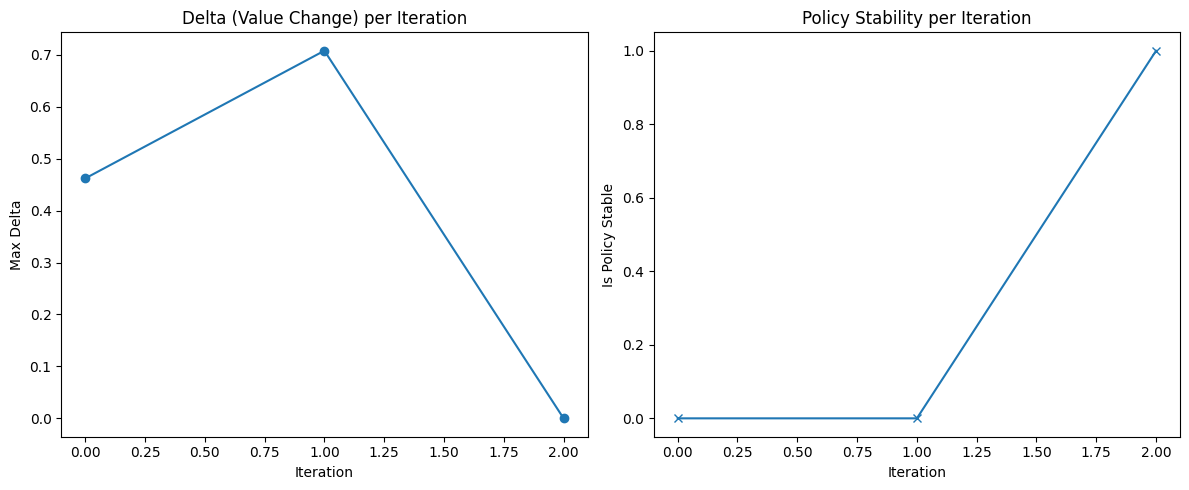

In [6]:
# 결과 시각화 (선택 사항)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 값 함수 변화 시각화
plt.subplot(1, 2, 1)
plt.plot(delta_list, marker='o')
plt.title("Delta (Value Change) per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Max Delta")

# 정책 안정 여부 시각화
plt.subplot(1, 2, 2)
plt.plot(policy_stable_list, marker='x')
plt.title("Policy Stability per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Is Policy Stable")

plt.tight_layout()
plt.show()

In [7]:
# 학습된 정책 테이블에서 각 위치에서 선택된 가장 확률 높은 행동 보기
import numpy as np
policy_arrows = {
    0: '↑',
    1: '↓',
    2: '←',
    3: '→'
}

for x in range(env.height):
    row = ""
    for y in range(env.width):
        if (x, y) == env.end_point:
            row += " G "
        else:
            probs = agent.policy_table[x][y]
            if not probs:
                row += " - "
            else:
                best = np.argmax(probs)
                row += f" {policy_arrows[best]} "
    print(row)


 ↓  ↓  ↓  ↓  ↓ 
 ↓  ↓  ↓  ↓  ↓ 
 ↓  ↓  ↓  ↓  ↓ 
 ↓  ↓  ↓  ↓  ↓ 
 →  →  →  →  G 


# 02. 가치 이터레이션
가치 이터레이션은 정책 없이 직접 가치 함수를 최적화하는 방법입니다.
- 스켈레톤 코드  
`init` 부를 제외한 나머지 매소드를 채워주세요.
1. value_iteration : 벨만 최적 방정식을 이용해 가치 함수를 반복적으로 업데이트
2. get_value : 현재 상태의 가치를 반환
3. get_action : 현재 가치 함수 기준으로 최적 행동 선택

In [8]:
class ValueIteration:
    def __init__(self, env):

        self.env = env
        self.action_space = env.action_space
        self.num_actions = env.num_actions

        # value 2d list
        self.value_table = np.zeros(shape=(env.height, env.width)).tolist()

        self.gamma = 0.9 # 할인율


    def value_iteration(self):
      threshold = 1e-4
      max_iterations = 1000
      delta_list = []

      for iteration in range(max_iterations):
          delta = 0
          next_value_table = [[0.0 for _ in range(self.env.width)] for _ in range(self.env.height)]

          for state in self.env.total_states:
              if state == self.env.end_point: # 종료 상태는 건너뜀
                  continue

              x, y = state
              value_list = []

              for action_idx in range(self.num_actions):
                  next_state = self.env.state_after_action(state, action_idx)
                  reward = self.env.get_reward(state, action_idx)
                  value = reward + self.gamma * self.get_value(next_state)
                  value_list.append(value)

              max_value = max(value_list)
              next_value_table[x][y] = max_value
              delta = max(delta, abs(self.value_table[x][y] - max_value))

          self.value_table = next_value_table
          delta_list.append(delta)

          if delta < threshold:
              print(f"Converged at iteration {iteration + 1}")
              break

      return delta_list



    def get_action(self, state):
      if state == self.env.end_point:
        return None

      action_values = []
      for action_idx in range(self.num_actions):
        next_state = self.env.state_after_action(state, action_idx)
        reward = self.env.get_reward(state, action_idx)
        value = reward + self.gamma * self.get_value(next_state)
        action_values.append(value)

      best_action_idx = np.argmax(action_values)
      return self.action_space[best_action_idx]


    def get_value(self, state):
        return self.value_table[state[0]][state[1]]

## 가치 이터레이션 실행
정의한 클래스를 이용해 정책 이터레이션을 실행해 주세요.

In [9]:
env = GridWorldEnvironment(start_point=(0, 0), end_point=(4, 4), grid_world_size=(5, 5))
vi = ValueIteration(env)
# 학습 실행
deltas = vi.value_iteration()

# 결과 확인
for x in range(env.height):
    row = ""
    for y in range(env.width):
        action = vi.get_action((x, y))
        row += f"{action[0].upper() if action else 'G'} "
    print(row)


Converged at iteration 9
D D D D D 
D D D D D 
D D D D D 
D D D D D 
R R R R G 


## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터/요소를 찾아 시각화해 주세요.

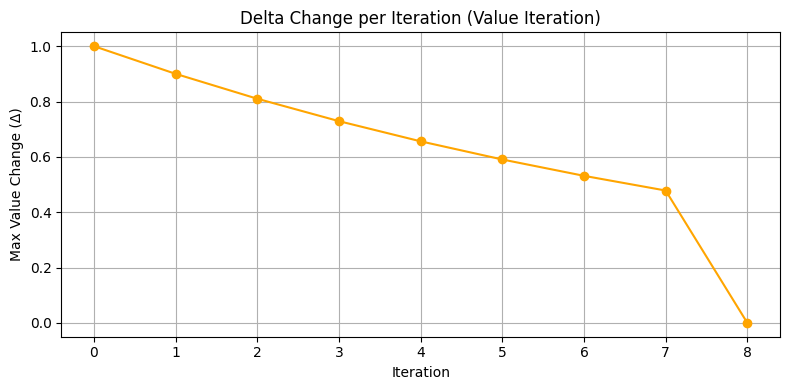

In [10]:
# 시각화
plt.figure(figsize=(8, 4))
plt.plot(deltas, marker='o', color='orange')
plt.title("Delta Change per Iteration (Value Iteration)")
plt.xlabel("Iteration")
plt.ylabel("Max Value Change (Δ)")
plt.grid(True)
plt.tight_layout()
plt.show()